In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd <your project directory>

In [3]:
!pwd

# Download and extract dataset

In [ ]:
!mkdir -p mvtecad_hazelnut_dataset
%cd mvtecad_hazelnut_dataset

!tar -xf /content/drive/MyDrive/AkriData_Project/hazelnut.tar.xz

# Navigate to hazelnut directory
!ls hazelnut/

# Data Analysis

In [ ]:
import os
import glob
from PIL import Image
from collections import Counter

# Check hazelnut dataset structure
# Updated path based on extraction location
hazelnut_path = "hazelnut" if os.path.exists("hazelnut") else "mvtecad_hazelnut_dataset/hazelnut"

print("=== MVTec AD Hazelnut Dataset Structure ===")
for split in ['train', 'test', 'ground_truth']:
    split_path = os.path.join(hazelnut_path, split)
    if os.path.exists(split_path):
        print(f"\n{split.upper()} Split:")
        subdirs = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]

        for subdir in subdirs:
            files = glob.glob(os.path.join(split_path, subdir, "*.png"))
            print(f"  {subdir}: {len(files)} images")

# Count total images
train_images = glob.glob(os.path.join(hazelnut_path, "train", "good", "*.png"))
test_images_list = glob.glob(os.path.join(hazelnut_path, "test", "*", "*.png"))

print(f"\nTotal hazelnut images:")
print(f"  Training: {len(train_images)}")
print(f"  Testing: {len(test_images_list)}")
print(f"  Grand Total: {len(train_images) + len(test_images_list)}")

# Analyze image sizes in the test folder
image_sizes = Counter()
for img_path in test_images_list:
    try:
        with Image.open(img_path) as img:
            image_sizes[img.size] += 1
    except Exception as e:
        print(f"Could not open image {img_path}: {e}")

print("\n=== Test Image Sizes ===")
if image_sizes:
    for size, count in image_sizes.most_common():
        print(f"  {size[0]}x{size[1]}: {count} images")
else:
    print("  No test images found or could not read image sizes.")

=== MVTec AD Hazelnut Dataset Structure ===

TRAIN Split:
  good: 391 images

TEST Split:
  cut: 17 images
  hole: 18 images
  crack: 18 images
  good: 40 images
  print: 17 images

GROUND_TRUTH Split:
  crack: 18 images
  hole: 18 images
  print: 17 images
  cut: 17 images

Total hazelnut images:
  Training: 391
  Testing: 110
  Grand Total: 501

=== Test Image Sizes ===
  1024x1024: 110 images


In [ ]:
!git clone https://github.com/PrudhviGudla/WinCLIP-Zero-Shot-Defect-Classification.git

In [4]:
#@title Move to the repo for subsequent work
%cd <your directory/repo>

In [5]:
#@title Verify that the files appear here
!ls

In [ ]:
#@title Copy test class folders to data directory
# You can skip this step if you want to directly use the test folder
!cp -r <your directory>/mvtecad_hazelnut_dataset/hazelnut/test/* <your directory>/data/

In [7]:
#@title Install the requirements from the `requirements.txt` file
!pip install -qr requirements.txt

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.7 MB/s eta 0:00:00


In [8]:
%%writefile spec.py
"""
Spec containing the configuration for the defect classification task
"""
from pydantic import BaseModel
from typing import List, Dict

class DefectClassificationSpec(BaseModel):
    """
    Configuration for defect classification.

    Attributes:
        model_name (str): Name of the CLIP model variant to use.
        normal_states (List[str]): List of state words for normal images.
        anomalous_states (List[str]): List of state words for anomalous images.
        defect_states (Dict[str, List[str]]): Dictionary of defect types and their corresponding state words.
        templates (List[str]): Prompt templates for CPE
        temperature (float): Temperature parameter for the CLIP model
    """

    # CLIP model configuration
    model_name: str = 'ViT-L/14'

    normal_states: List[str] = [
    # Quality descriptors
    "perfect", "flawless", "pristine", "intact", "unblemished",
    "high quality", "acceptable", "standard", "normal", "healthy", "good",

    # Shape and form descriptors
    "well formed", "properly shaped", "regular", "uniform", "symmetrical",

    # Surface and appearance descriptors
    "smooth", "clean", "clear", "bright", "fresh", "pure",

    # Structural integrity descriptors
    "solid", "whole", "complete", "unbroken", "sound", "robust", "firm",

    # Commercial quality descriptors
    "premium", "grade A", "first class", "superior", "excellent", "fine",

    # Condition descriptors
    "undamaged", "unmarked", "unprocessed", "natural", "untouched"
    # ,
    # "original", "best", "better"
]

    anomalous_states: List[str] = [
        "defective", "damaged", "broken", "faulty", "rejected",
        "poor quality", "unacceptable", "failed", "bad", "abnormal", "with flaw", "with defect", "with damage"
        # ,
        # "print damage", "cut damage", "crack damage", "hole damage"
    ]

    # Multi-class defect classification states
    defect_states: Dict[str, List[str]] = {
    'crack': [
        # Basic crack descriptors
        'cracked', 'fractured', 'split', 'broken',

        # Crack-specific terminology
        'fissured', 'creviced', 'cleft', 'rent', 'ruptured',
        'showing crack lines', 'with linear fractures', 'split open',
        'stress cracked', 'surface cracked', 'shell cracked',

        # Crack severity descriptors
        'hairline cracked', 'deeply cracked', 'partially cracked',
        'showing crack damage', 'with visible cracks'
    ],

    'cut': [
        # Basic cut descriptors
        'cut', 'sliced', 'severed', 'chopped',

        # Cut-specific terminology
        'incised', 'carved', 'gouged', 'scored', 'nicked',
        'with clean cuts', 'showing knife marks', 'mechanically cut',
        'sharp edge damaged', 'blade damaged', 'slicing damaged',

        # Cut pattern descriptors
        'straight cut', 'diagonal cut', 'partially cut',
        'showing cutting damage', 'with cut marks'
    ],

    'hole': [
        # Basic hole descriptors
        'holed', 'punctured', 'perforated', 'pierced',

        # Hole-specific terminology
        'bored', 'drilled', 'punched', 'penetrated', 'breached',
        'with round holes', 'showing void damage', 'cavity damaged',
        'tunnel damaged', 'bore hole damaged', 'entry hole damaged',

        # Hole size and type descriptors
        'pinhole damaged', 'large hole damaged', 'small hole damaged',
        'showing hole defect', 'with circular voids', 'hollow damaged'
    ],

    'print': [
        # Basic print descriptors
        'printed', 'marked', 'stained', 'discolored',

        # Print-specific terminology (from research findings)
        'ink stained', 'color marked', 'pigment stained', 'dye marked',
        'with white markings', 'showing print impressions', 'transfer printed',
        'contamination marked', 'residue stained', 'coating marked',

        # Print pattern descriptors
        'spotted with ink', 'streaked', 'blotched', 'smudged',
        'showing print damage', 'with surface contamination',
        'artificially marked', 'processing stained', 'white print markings'
    ]
}

    # CPE templates
    templates: List[str] = [
    'a cropped photo of the {} hazelnut',
    'a cropped photo of a {} hazelnut',
    'a close-up photo of a {} hazelnut',
    'a close-up photo of the {} hazelnut',
    'a bright photo of a {} hazelnut',
    'a bright photo of the {} hazelnut',
    'a dark photo of the {} hazelnut',
    'a dark photo of a {} hazelnut',
    'a jpeg corrupted photo of a {} hazelnut',
    'a jpeg corrupted photo of the {} hazelnut',
    'a blurry photo of the {} hazelnut',
    'a blurry photo of a {} hazelnut',
    'a photo of a {} hazelnut',
    'a photo of the {} hazelnut',
    'a photo of a small {} hazelnut',
    'a photo of the small {} hazelnut',
    'a photo of a large {} hazelnut',
    'a photo of the large {} hazelnut',
    'a photo of the {} hazelnut for visual inspection',
    'a photo of a {} hazelnut for visual inspection',
    'a photo of the {} hazelnut for anomaly detection',
    'a photo of a {} hazelnut for anomaly detection'
    ]

    # WinCLIP parameters
    temperature: float = 0.2

Overwriting spec.py


In [9]:
#@title TO DO: Modify `clip_ac.py` and save its contents
%%writefile clip_ac.py
"""
Zero-shot defect classification using CLIP
"""
import clip
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
from pathlib import Path
from typing import List, Tuple, Dict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support
import matplotlib.pyplot as plt
from spec import DefectClassificationSpec
import glob
import os
from itertools import product
from collections import Counter

class WinCLIPBinary:
    """
    WinCLIP Binary Classification (Normal vs Anomalous)
    """
    def __init__(self, spec: DefectClassificationSpec, model: torch.nn.Module):
        self.spec = spec
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = model

        print(f"WinCLIP Binary initialized for Normal vs Anomalous classification")

        # Build binary text prototypes using CPE
        self.normal_prototype, self.anomalous_prototype = self._build_binary_prototypes()

    def _build_binary_prototypes(self) -> Tuple[torch.Tensor, torch.Tensor]:
        """Builds binary text prototypes using Compositional Prompt Ensemble"""

        # Generate normal prompts (CPE)
        normal_prompts = []
        for state in self.spec.normal_states:
            for template in self.spec.templates:
                normal_prompts.append(template.format(state))

        # Generate anomalous prompts (CPE)
        anomalous_prompts = []
        for state in self.spec.anomalous_states:
            for template in self.spec.templates:
                anomalous_prompts.append(template.format(state))

        print(f"Generated {len(normal_prompts)} normal prompts")
        print(f"Generated {len(anomalous_prompts)} anomalous prompts")

        # Encode normal prompts
        normal_tokens = clip.tokenize(normal_prompts).to(self.device)
        with torch.no_grad():
            normal_features = self.model.encode_text(normal_tokens)
            normal_features = F.normalize(normal_features, p=2, dim=1)
            normal_prototype = normal_features.mean(dim=0, keepdim=True)

        # Encode anomalous prompts
        anomalous_tokens = clip.tokenize(anomalous_prompts).to(self.device)
        with torch.no_grad():
            anomalous_features = self.model.encode_text(anomalous_tokens)
            anomalous_features = F.normalize(anomalous_features, p=2, dim=1)
            anomalous_prototype = anomalous_features.mean(dim=0, keepdim=True)

        return normal_prototype, anomalous_prototype

    def classify_image_simple(self, image_features: torch.Tensor, threshold: float) -> Tuple[str, float]:
        """Classify single image: normal vs anomaly using only global image features and direct similarity comparison"""

        # Compute similarity to normal and anomalous prototypes
        normal_similarity = torch.matmul(image_features, self.normal_prototype.T).item()
        anomalous_similarity = torch.matmul(image_features, self.anomalous_prototype.T).item()

        anomaly_score = anomalous_similarity - normal_similarity

        # Predict class with higher similarity
        prediction = 'anomaly' if anomaly_score > threshold else 'normal'

        return prediction, anomaly_score


class WinCLIPMultiClass:
    """
    Multi-class defect classification (only for detected anomalies)
    """

    def __init__(self, spec: DefectClassificationSpec, model: torch.nn.Module):
        self.spec = spec
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = model
        self.class_prototypes = self._build_all_class_prototypes()
        self.defect_prototypes = self._build_defect_prototypes()
        print(f"WinCLIP Multi-class initialized")

    def _build_defect_prototypes(self) -> Dict[str, torch.Tensor]:
        """Build defect type prototypes using CPE"""
        prototypes = {}

        for defect_type, states in self.spec.defect_states.items():
            # Generate prompts for this defect type
            defect_prompts = []
            for state in states:
                for template in self.spec.templates:
                    defect_prompts.append(template.format(state))

            print(f"Generated {len(defect_prompts)} prompts for defect '{defect_type}'")

            # Encode prompts
            defect_tokens = clip.tokenize(defect_prompts).to(self.device)
            with torch.no_grad():
                defect_features = self.model.encode_text(defect_tokens)
                defect_features = F.normalize(defect_features, p=2, dim=1)
                prototype = defect_features.mean(dim=0, keepdim=True)
                prototypes[defect_type] = prototype

        return prototypes

    def _build_all_class_prototypes(self) -> Dict[str, torch.Tensor]:
        """Build defect type prototypes using CPE"""
        prototypes = {}

        for defect_type, states in self.spec.defect_states.items():
            # Generate prompts for this defect type
            defect_prompts = []
            for state in states:
                for template in self.spec.templates:
                    defect_prompts.append(template.format(state))

            print(f"Generated {len(defect_prompts)} prompts for defect '{defect_type}'")

            # Encode prompts
            defect_tokens = clip.tokenize(defect_prompts).to(self.device)
            with torch.no_grad():
                defect_features = self.model.encode_text(defect_tokens)
                defect_features = F.normalize(defect_features, p=2, dim=1)
                prototype = defect_features.mean(dim=0, keepdim=True)
                prototypes[defect_type] = prototype

        normal_prompts = []
        for state in self.spec.normal_states:
            for template in self.spec.templates:
                normal_prompts.append(template.format(state))

        normal_tokens = clip.tokenize(normal_prompts).to(self.device)
        with torch.no_grad():
            normal_features = self.model.encode_text(normal_tokens)
            normal_features = F.normalize(normal_features, p=2, dim=1)
            normal_prototype = normal_features.mean(dim=0, keepdim=True)

        prototypes["good"] = normal_prototype

        return prototypes

    def classify_defect_type(self, image_features: torch.Tensor) -> str:
        """Classify defect type (assumes image is already detected as anomalous)"""

        # Find best matching defect type
        best_similarity = -float('inf')
        best_defect = list(self.defect_prototypes.keys())[0]  # default

        for defect_type, prototype in self.defect_prototypes.items():
            similarity = torch.matmul(image_features, prototype.T).item()
            if similarity > best_similarity:
                best_similarity = similarity
                best_defect = defect_type

        return best_defect

    def classify_class(self, image_features: torch.Tensor) -> str:
        """Classify the class of the image"""

        # Find best matching defect type
        best_similarity = -float('inf')
        best_class = list(self.class_prototypes.keys())[0]  # default

        for class_type, prototype in self.class_prototypes.items():
            similarity = torch.matmul(image_features, prototype.T).item()
            if similarity > best_similarity:
                best_similarity = similarity
                best_class = class_type

        return best_class

# Util functions for loading images, classifying defects and printing results
def load_images_from_structure(test_dir: Path) -> List[Tuple[str, str]]:
    """Load images from dataset structure"""
    image_paths_labels = []
    classes = ['good', 'crack', 'cut', 'hole', 'print']

    for class_name in classes:
        class_dir = test_dir / class_name
        if class_dir.exists():
            images = list(class_dir.glob('*.png')) + list(class_dir.glob('*.jpg'))
            for img_path in images:
                image_paths_labels.append((str(img_path), class_name))

    return image_paths_labels

def load_defect_images_from_structure(test_dir: Path) -> List[Tuple[str, str]]:
    """Load only defect images from dataset structure for experiment"""
    image_paths_labels = []
    defect_classes = ['crack', 'cut', 'hole', 'print']

    for class_name in defect_classes:
        class_dir = test_dir / class_name
        if class_dir.exists():
            images = list(class_dir.glob('*.png')) + list(class_dir.glob('*.jpg'))
            for img_path in images:
                image_paths_labels.append((str(img_path), class_name))

    return image_paths_labels


def classify_defects(spec: DefectClassificationSpec, test_dir: Path, threshold: float) -> Tuple[List[str], List[str]]:
    """
    Complete two-stage classification: Binary + Multi-class
    """

    # Initialize Model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load(spec.model_name, device=device)
    print(f"CLIP initialized with {spec.model_name} on {device}")

    # Initialize both classifiers
    binary_classifier = WinCLIPBinary(spec, model)
    multiclass_classifier = WinCLIPMultiClass(spec, model)

    # Load test images
    image_paths_labels = load_images_from_structure(test_dir)
    print(f"Found {len(image_paths_labels)} test images")

    y_true_binary = []
    y_pred_binary = []
    anomaly_scores = []  # Add this to collect scores for ROC
    y_true_multi = []
    y_pred_multi = []

    for idx, (img_path, true_label) in enumerate(image_paths_labels):
        if idx % 10 == 0:
            print(f"Processing image {idx+1}/{len(image_paths_labels)}...")

        # Binary classification
        true_binary = 'normal' if true_label == 'good' else 'anomaly'
        y_true_binary.append(true_binary)

        image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

        with torch.no_grad():
            # Extract global image features
            image_features = model.encode_image(image)
            image_features = F.normalize(image_features, p=2, dim=1)

        # Stage 1: Classify normal vs binary
        pred_binary, anomaly_score = binary_classifier.classify_image_simple(image_features, threshold)
        y_pred_binary.append(pred_binary)
        anomaly_scores.append(anomaly_score)  # Collect anomaly scores

        # Multi-class classification
        y_true_multi.append(true_label)

        if pred_binary == 'normal':
            y_pred_multi.append('good')
        else:
            # Stage 2: Classify defect type
            defect_type = multiclass_classifier.classify_defect_type(image_features)
            y_pred_multi.append(defect_type)

    # Print results with ROC/AUC and precision/recall
    print_binary_results_with_roc(y_true_binary, y_pred_binary, anomaly_scores)
    print("\n=== Multi-class Classification with threshold = 0 for Binary Classification")
    print_multiclass_results_with_metrics(y_true_multi, y_pred_multi, flag=0)

    return y_true_multi, y_pred_multi

def classify_only_defects(spec: DefectClassificationSpec, test_dir: Path) -> Tuple[List[str], List[str]]:
    """
    Classify only defect images directly into defect types
    """

    # Initialize Model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load(spec.model_name, device=device)
    print(f"CLIP initialized with {spec.model_name} on {device}")

    # Initialize the multi-class classifier
    multiclass_classifier = WinCLIPMultiClass(spec, model)

    # Load only defect images
    image_paths_labels = load_defect_images_from_structure(test_dir)
    print(f"Found {len(image_paths_labels)} defect images")

    y_true = []
    y_pred = []

    print("\n=== Direct Defect Classification ===")

    for idx, (img_path, true_label) in enumerate(image_paths_labels):
        if idx % 10 == 0:
            print(f"Processing image {idx+1}/{len(image_paths_labels)}...")

        y_true.append(true_label)

        image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

        with torch.no_grad():
            # Extract global image features
            image_features = model.encode_image(image)
            image_features = F.normalize(image_features, p=2, dim=1)

        # Classify defect type directly
        pred_label = multiclass_classifier.classify_defect_type(image_features)
        y_pred.append(pred_label)

    # Print results
    print_multiclass_results_with_metrics(y_true, y_pred, flag=1)

    return y_true, y_pred

def classify_all_classes_direct(spec: DefectClassificationSpec, test_dir: Path) -> Tuple[List[str], List[str]]:
    """
    Directly classify images into all classes (good and defect types) based on state words. (experiment)
    """
    # Initialize Model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load(spec.model_name, device=device)
    print(f"CLIP initialized with {spec.model_name} on {device}")

    # Initialize the classifiers
    multiclass_classifier = WinCLIPMultiClass(spec, model)

    # Load all test images
    image_paths_labels = load_images_from_structure(test_dir)
    print(f"Found {len(image_paths_labels)} test images")

    y_true = []
    y_pred = []

    print("\n=== Direct Multi-class Classification (All Classes) ===")

    for idx, (img_path, true_label) in enumerate(image_paths_labels):
        if idx % 10 == 0:
            print(f"Processing image {idx+1}/{len(image_paths_labels)}...")

        y_true.append(true_label)

        image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

        with torch.no_grad():
            # Extract global image features
            image_features = model.encode_image(image)
            image_features = F.normalize(image_features, p=2, dim=1)

        # Classify defect type directly
        pred_label = multiclass_classifier.classify_class(image_features)
        y_pred.append(pred_label)

    # Print results
    print_multiclass_results_with_metrics(y_true, y_pred, flag=0)

    return y_true, y_pred

def print_binary_results_with_roc(y_true: List[str], y_pred: List[str], anomaly_scores: List[float]):
    """Print binary classification results with ROC curve and AUC"""

    print(f"\n{'='*60}")
    print("WINCLIP BINARY CLASSIFICATION RESULTS (Normal vs Anomaly)")
    print(f"{'='*60}")

    total = len(y_true)

    # Accuracy at threshold 0 (y_pred input)
    correct_0 = sum(1 for t, p in zip(y_true, y_pred) if t == p)
    accuracy_0 = correct_0 / total * 100

    print(f"Total samples: {total}")
    print(f"Accuracy at threshold=0 (given predictions): {correct_0}/{total} ({accuracy_0:.1f}%)")

    # Per-class results at threshold=0
    class_correct = Counter()
    class_total = Counter()

    for true_label, pred_label in zip(y_true, y_pred):
        class_total[true_label] += 1
        if true_label == pred_label:
            class_correct[true_label] += 1

    print(f"\nPer-class results at threshold=0:")
    for class_name in ['normal', 'anomaly']:
        if class_total[class_name] > 0:
            acc = class_correct[class_name] / class_total[class_name] * 100
            print(f"  {class_name:>8}: {class_correct[class_name]:>2}/{class_total[class_name]:>2} ({acc:>5.1f}%)")

    # ROC Curve and AUC
    y_true_bin = [1 if y == 'anomaly' else 0 for y in y_true]
    fpr, tpr, thresholds = roc_curve(y_true_bin, anomaly_scores)
    roc_auc = auc(fpr, tpr)

    print(f"\nROC AUC Score: {roc_auc:.4f}")

    # Find optimal threshold (closest to top-left corner)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimal threshold: {optimal_threshold:.4f}")

    # predictions at optimal threshold
    y_pred_optimal = ['anomaly' if score >= optimal_threshold else 'normal' for score in anomaly_scores]

    # Accuracy at optimal threshold
    correct_opt = sum(1 for t, p in zip(y_true, y_pred_optimal) if t == p)
    accuracy_opt = correct_opt / total * 100
    print(f"Accuracy at optimal threshold: {correct_opt}/{total} ({accuracy_opt:.1f}%)")

    # Precision, recall, f1-score calculations
    labels = ['normal', 'anomaly']

    # At threshold=0
    prec_0, recall_0, f1_0, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, zero_division=0
    )

    # At optimal threshold
    prec_opt, recall_opt, f1_opt, _ = precision_recall_fscore_support(
        y_true, y_pred_optimal, labels=labels, zero_division=0
    )

    print(f"\n{'='*40}")
    print("DETAILED METRICS COMPARISON")
    print(f"{'='*40}")

    print(f"\nMetrics at threshold=0:")
    for i, label in enumerate(labels):
        print(f"  {label:>8}: Precision: {prec_0[i]:.3f}, Recall: {recall_0[i]:.3f}, F1-score: {f1_0[i]:.3f}")
    print(f"\nOverall Precision: {prec_0.mean():.3f}, Recall: {recall_0.mean():.3f}, F1-score: {f1_0.mean():.3f}")

    print(f"\nMetrics at optimal threshold ({optimal_threshold:.4f}):")
    for i, label in enumerate(labels):
        print(f"  {label:>8}: Precision: {prec_opt[i]:.3f}, Recall: {recall_opt[i]:.3f}, F1-score: {f1_opt[i]:.3f}")
    print(f"\nOverall Precision: {prec_opt.mean():.3f}, Recall: {recall_opt.mean():.3f}, F1-score: {f1_opt.mean():.3f}")

    # Show improvement
    print(f"\nAccuracy improvement: {accuracy_opt - accuracy_0:+.1f}%")

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=100,
                label=f'Optimal threshold = {optimal_threshold:.3f}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve - Binary Classification')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Confusion Matrices side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Confusion Matrix at threshold=0
    cm_0 = confusion_matrix(y_true, y_pred, labels=labels)
    disp_0 = ConfusionMatrixDisplay(confusion_matrix=cm_0, display_labels=labels)
    disp_0.plot(cmap=plt.cm.Blues, ax=ax1)
    ax1.set_title(f'Confusion Matrix (Threshold=0)\nAccuracy: {accuracy_0:.1f}%')

    # Confusion Matrix at optimal threshold
    cm_opt = confusion_matrix(y_true, y_pred_optimal, labels=labels)
    disp_opt = ConfusionMatrixDisplay(confusion_matrix=cm_opt, display_labels=labels)
    disp_opt.plot(cmap=plt.cm.Blues, ax=ax2)
    ax2.set_title(f'Confusion Matrix (Optimal Threshold={optimal_threshold:.3f})\nAccuracy: {accuracy_opt:.1f}%')

    plt.tight_layout()
    plt.show()

def print_multiclass_results_with_metrics(y_true: List[str], y_pred: List[str], flag: bool):
    """Print multi-class classification results with precision and recall
       flag = 0 for all classes, 1 for only defect classes
    """
    print(f"\n{'='*60}")
    if flag == 1:
        classes = ['crack', 'cut', 'hole', 'print']
        print("WINCLIP MULTI-CLASS DEFECT CLASSIFICATION RESULTS")
    elif flag == 0:
        classes = ['good', 'crack', 'cut', 'hole', 'print']
        print("WINCLIP MULTI-CLASS CLASSIFICATION RESULTS")
    print(f"{'='*60}")

    correct = sum(1 for t, p in zip(y_true, y_pred) if t == p)
    total = len(y_true)
    accuracy = correct / total * 100

    print(f"Total samples: {total}")
    print(f"Overall accuracy: {correct}/{total} ({accuracy:.1f}%)")

    # Per-class results
    class_correct = Counter()
    class_total = Counter()

    for true_label, pred_label in zip(y_true, y_pred):
        class_total[true_label] += 1
        if true_label == pred_label:
            class_correct[true_label] += 1

    print(f"\nPer-class results:")
    for class_name in classes:
        if class_total[class_name] > 0:
            acc = class_correct[class_name] / class_total[class_name] * 100
            print(f"  {class_name:>8}: {class_correct[class_name]:>2}/{class_total[class_name]:>2} ({acc:>5.1f}%)")
        else:
             print(f"  {class_name:>8}: No samples found")

    # Precision and Recall for each class
    precision, recall, f1_score, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=classes, zero_division=0
    )

    print(f"\nPer-class Precision, Recall, and F1-Score:")
    for cls, p, r, f1 in zip(classes, precision, recall, f1_score):
        if cls in set(y_true):  # Only show metrics for classes present in test set
            print(f"  {cls:>8}: Precision: {p:.3f}, Recall: {r:.3f}, F1: {f1:.3f}")

    print(f"\nOverall Precision, Recall, and F1-Score:")
    print(f"  Precision: {precision.mean():.3f}, Recall: {recall.mean():.3f}, F1: {f1_score.mean():.3f}")

    # misclassifications
    misclassifications = [(t, p) for t, p in zip(y_true, y_pred) if t != p]
    if misclassifications:
        print(f"\nMisclassifications ({len(misclassifications)}):")
        misclass_counter = Counter(misclassifications)
        for (true_class, pred_class), count in misclass_counter.most_common():
            print(f"  {true_class} → {pred_class}: {count} times")

    # Confusion Matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()



Overwriting clip_ac.py


100%|███████████████████████████████████████| 890M/890M [00:15<00:00, 60.0MiB/s]


CLIP initialized with ViT-L/14 on cuda
WinCLIP Binary initialized for Normal vs Anomalous classification
Generated 880 normal prompts
Generated 286 anomalous prompts
Generated 440 prompts for defect 'crack'
Generated 440 prompts for defect 'cut'
Generated 462 prompts for defect 'hole'
Generated 506 prompts for defect 'print'
Generated 440 prompts for defect 'crack'
Generated 440 prompts for defect 'cut'
Generated 462 prompts for defect 'hole'
Generated 506 prompts for defect 'print'
WinCLIP Multi-class initialized
Found 110 test images
Processing image 1/110...
Processing image 11/110...
Processing image 21/110...
Processing image 31/110...
Processing image 41/110...
Processing image 51/110...
Processing image 61/110...
Processing image 71/110...
Processing image 81/110...
Processing image 91/110...
Processing image 101/110...

WINCLIP BINARY CLASSIFICATION RESULTS (Normal vs Anomaly)
Total samples: 110
Accuracy at threshold=0 (given predictions): 86/110 (78.2%)

Per-class results at t

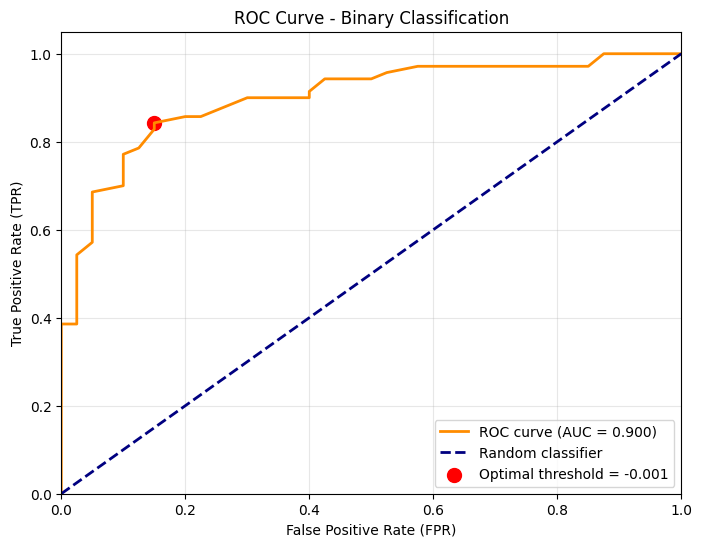

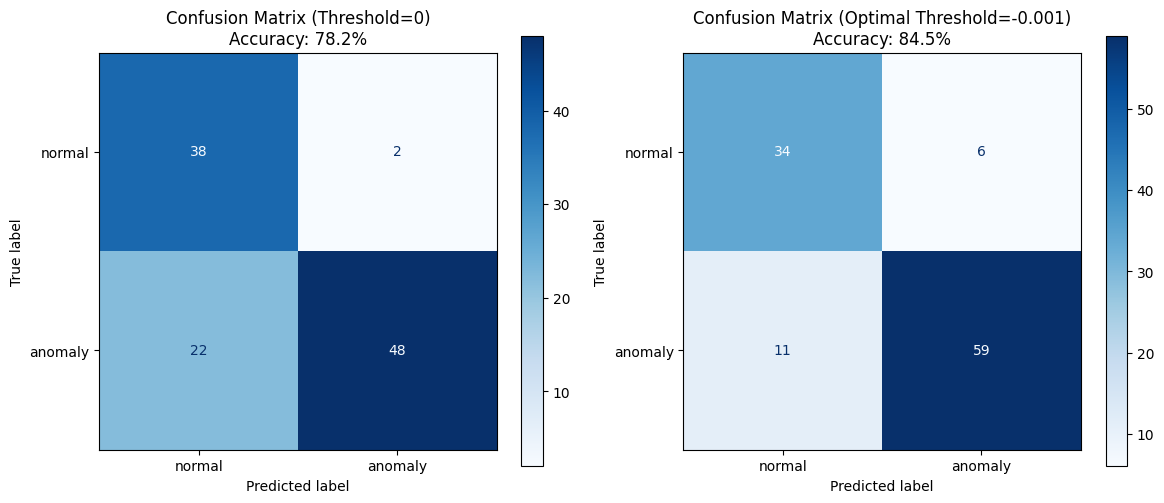


=== Multi-class Classification with threshold = 0 for Binary Classification

WINCLIP MULTI-CLASS CLASSIFICATION RESULTS
Total samples: 110
Overall accuracy: 71/110 (64.5%)

Per-class results:
      good: 38/40 ( 95.0%)
     crack: 14/18 ( 77.8%)
       cut:  4/17 ( 23.5%)
      hole: 14/18 ( 77.8%)
     print:  1/17 (  5.9%)

Per-class Precision, Recall, and F1-Score:
      good: Precision: 0.633, Recall: 0.950, F1: 0.760
     crack: Precision: 0.538, Recall: 0.778, F1: 0.636
       cut: Precision: 0.800, Recall: 0.235, F1: 0.364
      hole: Precision: 0.778, Recall: 0.778, F1: 0.778
     print: Precision: 1.000, Recall: 0.059, F1: 0.111

Overall Precision, Recall, and F1-Score:
  Precision: 0.750, Recall: 0.560, F1: 0.530

Misclassifications (39):
  print → good: 13 times
  cut → good: 8 times
  cut → crack: 4 times
  hole → crack: 4 times
  crack → hole: 3 times
  print → crack: 3 times
  good → cut: 1 times
  good → crack: 1 times
  crack → good: 1 times
  cut → hole: 1 times

Conf

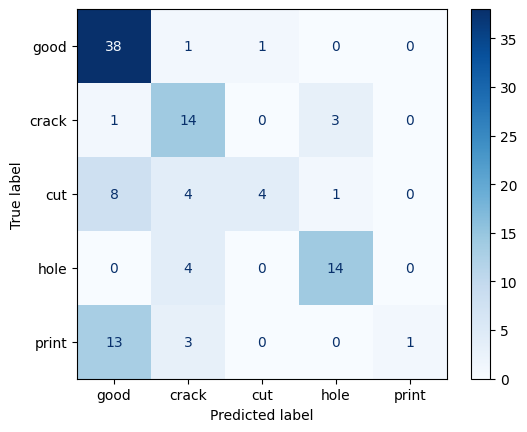

In [10]:
# Reload the spec and clip_ac modules if you modified them with %%writefile
import importlib
import spec
import clip_ac
importlib.reload(clip_ac)
importlib.reload(spec)

from spec import DefectClassificationSpec
from pathlib import Path
import json
from clip_ac import classify_defects

spec = DefectClassificationSpec()
test_dir = Path("data")  # Update with your path

# Run complete classification (binary + multi-class in one call)
y_true, y_pred = classify_defects(spec, test_dir, threshold = 0)

CLIP initialized with ViT-L/14 on cuda
Generated 440 prompts for defect 'crack'
Generated 440 prompts for defect 'cut'
Generated 462 prompts for defect 'hole'
Generated 506 prompts for defect 'print'
Generated 440 prompts for defect 'crack'
Generated 440 prompts for defect 'cut'
Generated 462 prompts for defect 'hole'
Generated 506 prompts for defect 'print'
WinCLIP Multi-class initialized
Found 110 test images

=== Direct Multi-class Classification (All Classes) ===
Processing image 1/110...
Processing image 11/110...
Processing image 21/110...
Processing image 31/110...
Processing image 41/110...
Processing image 51/110...
Processing image 61/110...
Processing image 71/110...
Processing image 81/110...
Processing image 91/110...
Processing image 101/110...

WINCLIP MULTI-CLASS CLASSIFICATION RESULTS
Total samples: 110
Overall accuracy: 42/110 (38.2%)

Per-class results:
      good:  0/40 (  0.0%)
     crack: 14/18 ( 77.8%)
       cut: 12/17 ( 70.6%)
      hole: 14/18 ( 77.8%)
     pr

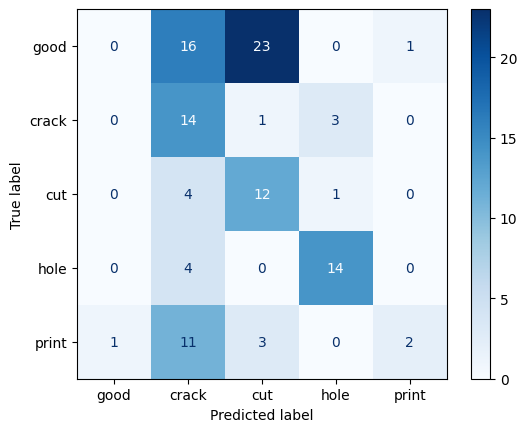

In [11]:
from clip_ac import classify_all_classes_direct
y_true, y_pred = classify_all_classes_direct(spec, test_dir)

CLIP initialized with ViT-L/14 on cuda
Generated 440 prompts for defect 'crack'
Generated 440 prompts for defect 'cut'
Generated 462 prompts for defect 'hole'
Generated 506 prompts for defect 'print'
Generated 440 prompts for defect 'crack'
Generated 440 prompts for defect 'cut'
Generated 462 prompts for defect 'hole'
Generated 506 prompts for defect 'print'
WinCLIP Multi-class initialized
Found 70 defect images

=== Direct Defect Classification ===
Processing image 1/70...
Processing image 11/70...
Processing image 21/70...
Processing image 31/70...
Processing image 41/70...
Processing image 51/70...
Processing image 61/70...

WINCLIP MULTI-CLASS DEFECT CLASSIFICATION RESULTS
Total samples: 70
Overall accuracy: 42/70 (60.0%)

Per-class results:
     crack: 14/18 ( 77.8%)
       cut: 12/17 ( 70.6%)
      hole: 14/18 ( 77.8%)
     print:  2/17 ( 11.8%)

Per-class Precision, Recall, and F1-Score:
     crack: Precision: 0.424, Recall: 0.778, F1: 0.549
       cut: Precision: 0.706, Recall:

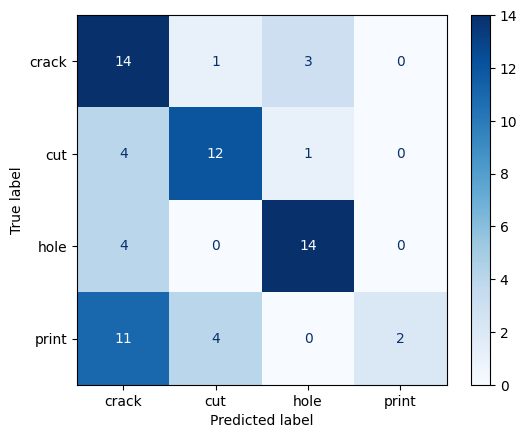

In [12]:
from clip_ac import classify_only_defects
y_true, y_pred = classify_only_defects(spec, test_dir)